In [1]:
import shutil
import time

import matplotlib.pyplot as plt
import pingouin as pg
import numpy as np
import pandas as pd
from fsspec.implementations.local import LocalFileSystem
from dask import delayed
from dask.distributed import Client, LocalCluster

from dummy_baskets import generate_dummy_baskets, run_index_basket_upload_test
from weave.index.index_pandas import IndexPandas
from weave.index.index_sqlite import IndexSQLite
from weave.index.index_sql import IndexSQL
from weave import Pantry

In this notebok we will run 5 upload tests on each index backend (IndexPandas, IndexSQLite, IndexSQL) and compare the average upload time. We will be using 1000 baskets, 10 upload files, 1 MB file size, and 5 basket types as the parameters in each test. Statistical tests will be performed across the three different index backends to determine if there is a statistical significant difference in upload time between all the index backends.

Index Pandas Tests

In [20]:
pandas_times = []
baskets = generate_dummy_baskets(basket_count=1000, file_count=10, file_size_mb=1, file_path="dummy_txt", num_basket_types=5)

for _ in range(5):
    pantry_pandas = Pantry(IndexPandas, pantry_path="dummy_pantry", file_system=LocalFileSystem())
    test_time = run_index_basket_upload_test(basket_list=baskets, pantry=pantry_pandas)
    pandas_times.append(test_time)
    shutil.rmtree("dummy_pantry")

shutil.rmtree("dummy_txt")

print(f"Pandas index upload times: {pandas_times}")
print(f"Average pandas index upload time for 5 different tests: {np.mean(pandas_times)}")

Pandas index upload times: [183.0740385055542, 224.86337041854858, 189.71711921691895, 188.273184299469, 312.51142859458923]
Average pandas index upload time for 5 different tests: 219.687828207016


Index SQLite Tests

In [21]:
sqlite_times = []
baskets = generate_dummy_baskets(basket_count=1000, file_count=10, file_size_mb=1, file_path="dummy_txt", num_basket_types=5)

for _ in range(5):
    pantry_sqlite = Pantry(IndexSQLite, pantry_path="dummy_pantry", file_system=LocalFileSystem())
    test_time = run_index_basket_upload_test(basket_list=baskets, pantry=pantry_sqlite)
    sqlite_times.append(test_time)
    shutil.rmtree("dummy_pantry")
    pantry_sqlite.index.drop_index()

shutil.rmtree("dummy_txt")

print(f"SQLite index upload times: {sqlite_times}")
print(f"Average SQLite index upload time for 5 different tests: {np.mean(sqlite_times)}")

SQLite index upload times: [51.797475814819336, 48.11146354675293, 48.86608600616455, 44.29097294807434, 50.7223641872406]
Average SQLite index upload time for 5 different tests: 48.757672500610354


Index SQL Tests

In [22]:
sql_times = []
baskets = generate_dummy_baskets(basket_count=1000, file_count=10, file_size_mb=1, file_path="dummy_txt", num_basket_types=5)

for _ in range(5):
    pantry_sql = Pantry(IndexSQL, pantry_path="dummy_pantry", file_system=LocalFileSystem())
    test_time = run_index_basket_upload_test(basket_list=baskets, pantry=pantry_sql)
    sql_times.append(test_time)
    shutil.rmtree("dummy_pantry")
    pantry_sql.index.drop_index()

shutil.rmtree("dummy_txt")

print(f"SQL index upload times: {sql_times}")
print(f"Average SQL index upload time for 5 different tests: {np.mean(sql_times)}")

SQL index upload times: [36.481626987457275, 35.98214626312256, 35.64037036895752, 35.77695393562317, 36.6458683013916]
Average SQL index upload time for 5 different tests: 36.105393171310425


Performance Difference Between all 3 Index Backends

In [23]:
index_times_df = pd.DataFrame({
    "Pandas Index": pandas_times,
    "SQLite Index": sqlite_times,
    "SQL Index": sql_times
})
index_times_df

,Pandas Index,SQLite Index,SQL Index
0,183.074039,51.797476,36.481627
1,224.863370,48.111464,35.982146
2,189.717119,48.866086,35.640370
3,188.273184,44.290973,35.776954
4,312.511429,50.722364,36.645868


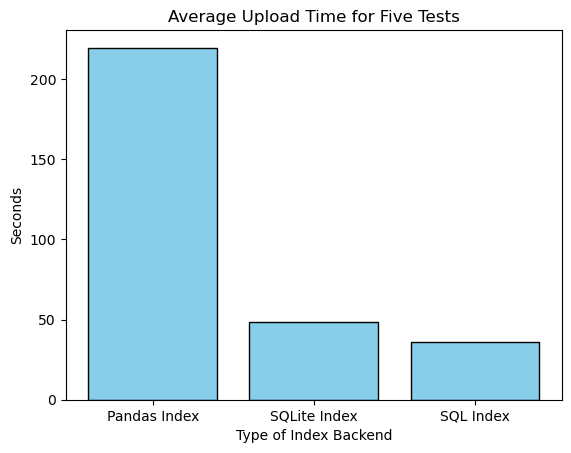

In [24]:
categories = ["Pandas Index", "SQLite Index", "SQL Index"]
values = [np.mean(pandas_times), np.mean(sqlite_times), np.mean(sql_times)]

plt.bar(categories, values, color='skyblue', edgecolor='black')

plt.xlabel('Type of Index Backend')
plt.ylabel('Seconds')
plt.title('Average Upload Time for Five Tests')

plt.show()

In [25]:
all_times = pandas_times + sqlite_times + sql_times

times_df = pd.DataFrame({
    "Index": ["Pandas"] * 5 + ["SQLite"] * 5 + ["SQL"] * 5,
    "Upload_Time": all_times
})

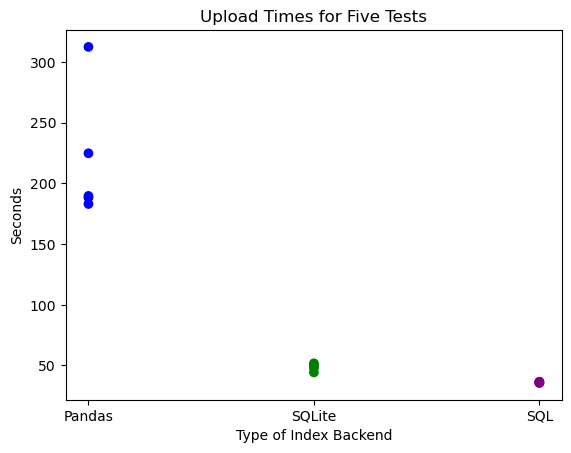

In [26]:
color_map = {"Pandas": "blue", "SQLite": "green", "SQL": "purple"}
colors = times_df['Index'].map(color_map)

plt.scatter(times_df['Index'], times_df['Upload_Time'], c=colors)

plt.xlabel('Type of Index Backend')
plt.ylabel('Seconds')
plt.title('Upload Times for Five Tests')

plt.show()

ANOVA Test Between the Three Index Backends

In [27]:
pg.anova(data=times_df, dv='Upload_Time', between='Index')

,Source,ddof1,ddof2,F,p-unc,np2
0,Index,2,12,52.995003,0.000001,0.898296


Since we have a p-value of less than 0.05 we can say that the average upload times between index backends are statistically different.
Now we can perform a post-hoc analysis to determine which specific index upload times are statistically different between each other.

In [28]:
times_df.pairwise_tukey(dv='Upload_Time', between='Index').round(3)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Pandas,SQL,219.688,36.105,183.582,19.919,9.216,0.000,4.305
1,Pandas,SQLite,219.688,48.758,170.930,19.919,8.581,0.000,4.003
2,SQL,SQLite,36.105,48.758,-12.652,19.919,-0.635,0.804,-5.523


Since each p-value in the post-hoc analysis (besides the difference between SQL and SQLite) is less than 0.05, we can determine that there is a statistically significant difference between the Pandas and SQL indexes, and the Pandas and SQLite indexes.

Indexes Ranked by Upload Time:
1. SQL
2. SQLite
3. Pandas

***We are now going to run all of the same tests using 5 concurrent processes instead of one. However, we will only be testing***
***with SQLite and SQL as the Pandas Index does not work with concurrency***

In [11]:
# Set up a local cluster and client with 5 concurrent processes
cluster = LocalCluster(n_workers=5, threads_per_worker=1, processes=True)
client = Client(cluster)

**Index SQLite Concurrency Tests**

In [13]:
con_sqlite_times = []
baskets = generate_dummy_baskets(basket_count=1000, file_count=10, file_size_mb=1, file_path="dummy_txt", num_basket_types=5)

for _ in range(5):
    pantry = Pantry(IndexSQLite, pantry_path="dummy_pantry", file_system=LocalFileSystem())
    
    # Create a delayed function to upload all of our chunks
    @delayed
    def upload_chunk(chunk):
        pantry = Pantry(IndexSQLite, pantry_path="dummy_pantry", file_system=LocalFileSystem())
        run_index_basket_upload_test(chunk, pantry)

    # Create 5 equal chunks each with 200 baskets
    chunks = [baskets[i:i+200] for i in range(0, len(baskets), 200)]

    # Upload all chunks in parallel
    delayed_uploads = [upload_chunk(chunk) for chunk in chunks]

    start_time = time.time()
    results = client.compute(delayed_uploads, sync=True)
    end_time = time.time()
    test_time = end_time - start_time

    con_sqlite_times.append(test_time)
    shutil.rmtree("dummy_pantry")
    pantry.index.drop_index()

shutil.rmtree("dummy_txt")

print(f"SQLite index upload times with 5 concurrent processes: {con_sqlite_times}")
print(f"Average sqlite index upload time for 5 different tests: {np.mean(con_sqlite_times)}")

SQLite index upload times with 5 concurrent processes: [18.143439531326294, 17.832154273986816, 17.978291273117065, 18.14603090286255, 17.76979970932007]
Average sqlite index upload time for 5 different tests: 17.973943138122557


**Index SQLite Concurrency Tests**

In [14]:
con_sql_times = []
baskets = generate_dummy_baskets(basket_count=1000, file_count=10, file_size_mb=1, file_path="dummy_txt", num_basket_types=5)

for _ in range(5):
    pantry = Pantry(IndexSQL, pantry_path="dummy_pantry", file_system=LocalFileSystem())
    
    # Create a delayed function to upload all of our chunks
    @delayed
    def upload_chunk(chunk):
        pantry = Pantry(IndexSQL, pantry_path="dummy_pantry", file_system=LocalFileSystem())
        run_index_basket_upload_test(chunk, pantry)

    # Create 5 equal chunks each with 200 baskets
    chunks = [baskets[i:i+200] for i in range(0, len(baskets), 200)]

    # Upload all chunks in parallel
    delayed_uploads = [upload_chunk(chunk) for chunk in chunks]

    start_time = time.time()
    results = client.compute(delayed_uploads, sync=True)
    end_time = time.time()
    test_time = end_time - start_time

    con_sql_times.append(test_time)
    shutil.rmtree("dummy_pantry")
    pantry.index.drop_index()

shutil.rmtree("dummy_txt")

print(f"SQL index upload times with 5 concurrent processes: {con_sql_times}")
print(f"Average SQL index upload time for 5 different tests: {np.mean(con_sql_times)}")

SQL index upload times with 5 concurrent processes: [9.457438230514526, 9.557574272155762, 9.530535697937012, 9.62836766242981, 9.402531385421753]
Average SQL index upload time for 5 different tests: 9.515289449691773


Concurrency performance difference between SQLite and SQL indexes

In [15]:
con_index_times_df = pd.DataFrame({
    "SQLite Index Concurrency": con_sqlite_times,
    "SQL Index Concurrency": con_sql_times
})
con_index_times_df

,SQLite Index Concurrency,SQL Index Concurrency
0,18.143440,9.457438
1,17.832154,9.557574
2,17.978291,9.530536
3,18.146031,9.628368
4,17.769800,9.402531


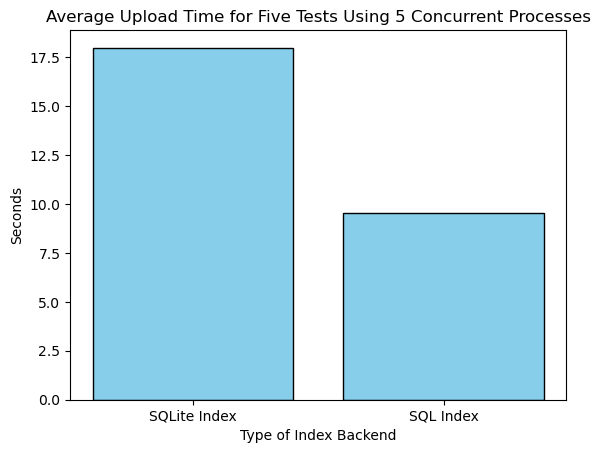

In [16]:
categories = ["SQLite Index", "SQL Index"]
values = [np.mean(con_sqlite_times), np.mean(con_sql_times)]

plt.bar(categories, values, color='skyblue', edgecolor='black')

plt.xlabel('Type of Index Backend')
plt.ylabel('Seconds')
plt.title('Average Upload Time for Five Tests Using 5 Concurrent Processes')

plt.show()

In [17]:
con_all_times = con_sqlite_times + con_sql_times

con_times_df = pd.DataFrame({
    "Index": ["SQLite"] * 5 + ["SQL"] * 5,
    "Upload_Time": con_all_times
})

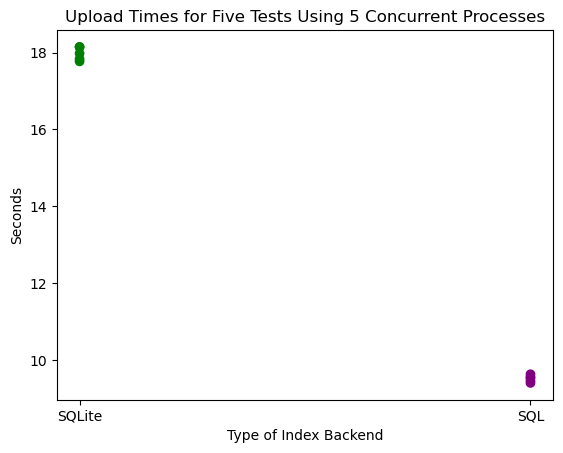

In [18]:
color_map = {"SQLite": "green", "SQL": "purple"}
colors = con_times_df['Index'].map(color_map)

plt.scatter(con_times_df['Index'], con_times_df['Upload_Time'], c=colors)

plt.xlabel('Type of Index Backend')
plt.ylabel('Seconds')
plt.title('Upload Times for Five Tests Using 5 Concurrent Processes')

plt.show()

2 sample t-test between the sqlite and SQL index backends

In [19]:
pg.ttest(con_sqlite_times, con_sql_times)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,97.345253,8,two-sided,1.384779e-13,"[8.26, 8.66]",61.566544,7.318e+09,1.0


Since we have a p-value of less than 0.05, we can deduce that there is a statistically significant difference in concurrent upload
speeds between the sqlite and SQL index backends. The SQL backend has a faster upload time for 1000 baskets using 5 concurrent processes